In [1]:
import json
import bz2
import regex
import pandas as pd
import numpy as np
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
import re
from tqdm import tqdm
from scipy import sparse
import warnings
warnings.filterwarnings('ignore')
import matplotlib
matplotlib.style.use('ggplot')
from pylab import rcParams
rcParams['figure.figsize'] = 10, 8
from nltk.corpus import stopwords
# from natasha import LocationExtractor
%matplotlib inline
%pylab inline
%config InlineBackend.figure_format = 'retina'

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [2]:
responses = []
with bz2.BZ2File('../../src/nlp-homeworks-main/banki_responses.json.bz2', 'r') as thefile:
    for row in tqdm(thefile):
        resp = json.loads(row)
        if not resp['rating_not_checked'] and (len(resp['text'].split()) > 0):
            responses.append(resp)

201030it [00:47, 4190.62it/s]


## Классификация обращений по тональности

In [3]:
responses[15]

{'city': 'г. Ростов-на-Дону',
 'rating_not_checked': False,
 'title': 'Нет зачисления платежа через банкомат ОТП банка!',
 'num_comments': 1,
 'bank_license': 'лицензия № 2766',
 'author': 'tamara-an',
 'bank_name': 'ОТП Банк',
 'datetime': '2015-06-05 14:01:49',
 'text': '02-06-2015 были произведены 2 платежа\xa0через банкомат в г. Ростов-на-Дону по адресу Добровольского 1\xa0(офис банка ОТП Банк). Первый платеж в 20:39. Второй платеж в 20:40. ОДНАКО первый платеж так и не поступил. При этом второй платеж был практически моментально зачислен. Оплата производилась с одной и той же карты в одном и том же банкомате. О данной ситуации было написано письмо на адрес:\xa0zabota(at)otpbank.ru 3 июня 2015 г. однако никакого ответа НЕ ПОСЛЕДОВАЛО! (В письме были точные реквизиты услуги, сканы чеков). ПРОСИМ РЕШИТЬ проблему оперативно! В комментариях для представителя банка детальная информация изложена. При необходимости сканы повторно вышлем.',
 'rating_grade': None}

Анализ текстов

In [4]:
data = pd.DataFrame(responses)
data = data.sample(frac=0.05)
data.head(3)

,city,rating_not_checked,title,num_comments,bank_license,author,bank_name,datetime,text,rating_grade
39937,г. Москва,False,Два года безуспешно пытаюсь перейти в НПФ Сбер...,0,лицензия № 1481,l22,Сбербанк России,2014-07-22 12:58:00,Два года безуспешно пытаюсь перейти в НПФ Сбер...,1.0
46909,г. Нижневартовск,False,Прошу разобраться в закрытии моих счетов ранее...,0,лицензия № 2766,sh.tatiana71,ОТП Банк,2014-05-22 10:57:00,Прошу вас закрыть по кредитным договорам №1871...,NaN
66909,г. Москва,False,Договор о сотрудничестве с застройщиком,0,лицензия № 1481,katybv86,Сбербанк России,2013-11-21 12:39:00,"Добрый день. Хотела бы узнать у Сбербанка, ск...",NaN


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 15350 entries, 39937 to 17982
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   city                13840 non-null  object 
 1   rating_not_checked  15350 non-null  bool   
 2   title               15350 non-null  object 
 3   num_comments        15350 non-null  int64  
 4   bank_license        15350 non-null  object 
 5   author              15349 non-null  object 
 6   bank_name           15350 non-null  object 
 7   datetime            15350 non-null  object 
 8   text                15350 non-null  object 
 9   rating_grade        8948 non-null   float64
dtypes: bool(1), float64(1), int64(1), object(7)
memory usage: 1.2+ MB


### 1. Количество отзывов в разных городах и банках

In [6]:
# https://habr.com/ru/post/21949/

ct = pd.read_csv('../../src/city.csv', sep=';', encoding='cp1251')
ct.head()

,city_id,country_id,region_id,name
0,4400,3159,4312,Москва
1,4313,3159,4312,Абрамцево
2,4314,3159,4312,Алабино
3,4315,3159,4312,Апрелевка
4,4316,3159,4312,Архангельское


In [7]:
X_df1, Y_df2 = data.city, ct.name

speech_recognition = X_df1.to_list()
claim_list = Y_df2.to_list()

In [8]:
import Levenshtein

def n_sort(x=claim_list, y=speech_recognition):
    l = Levenshtein.distance
    result = []
    for i in y:
        b = sorted({r: l(i, r) for r in x}.items(), key = lambda x: x[1])[0]
        result.append(
            ['Ввели: "{}" - Хотели ввести: "{}" - Кол-во min: "{}"'.format(i, b[0], b[1])]
        ) 
    return result

In [9]:
n_sort(claim_list, speech_recognition[50])

[['Ввели: "г" - Хотели ввести: "Яя" - Кол-во min: "2"'],
 ['Ввели: "." - Хотели ввести: "Яя" - Кол-во min: "2"'],
 ['Ввели: " " - Хотели ввести: "Яя" - Кол-во min: "2"'],
 ['Ввели: "М" - Хотели ввести: "Яя" - Кол-во min: "2"'],
 ['Ввели: "о" - Хотели ввести: "По" - Кол-во min: "1"'],
 ['Ввели: "с" - Хотели ввести: "Ис" - Кол-во min: "1"'],
 ['Ввели: "к" - Хотели ввести: "Яя" - Кол-во min: "2"'],
 ['Ввели: "в" - Хотели ввести: "Хив" - Кол-во min: "2"'],
 ['Ввели: "а" - Хотели ввести: "Уфа" - Кол-во min: "2"']]

Левинштейн не везде справился :
 ['Ввели: "г. Таганрог (Ростовская обл.)" - Хотели ввести: "Сургут (Самарская обл.)" - Кол-во min: "16"'],

In [10]:
from natasha import LocationExtractor

def extract_city(text):
    if isinstance(text, str):
        extractor = LocationExtractor()
        matches = extractor(text)
        if len(matches) > 0:
            return matches[0].fact.name
        else:
            return None
    else:
        return None

In [11]:
cities = pd.DataFrame(data.city.unique(), columns=['orig_name'])
cities['clean_name'] = cities['orig_name'].apply(extract_city)

In [12]:
cities.head()

,orig_name,clean_name
0,г. Москва,москва
1,г. Нижневартовск,нижневартовск
2,г. Ростов-на-Дону,ростов
3,г. Нижний Новгород,нижний новгород
4,г. Салават,салават


In [13]:
on = cities.orig_name.value_counts().sum()
cn = cities.clean_name.value_counts().sum()

print('\n{0}'.format(int(on-cn)))


159


In [14]:
data['clean_city'] = data['city'].replace(cities['orig_name'].tolist(), cities['clean_name'].str.title().tolist())

In [15]:
data.head(3)

,city,rating_not_checked,title,num_comments,bank_license,author,bank_name,datetime,text,rating_grade,clean_city
39937,г. Москва,False,Два года безуспешно пытаюсь перейти в НПФ Сбер...,0,лицензия № 1481,l22,Сбербанк России,2014-07-22 12:58:00,Два года безуспешно пытаюсь перейти в НПФ Сбер...,1.0,Москва
46909,г. Нижневартовск,False,Прошу разобраться в закрытии моих счетов ранее...,0,лицензия № 2766,sh.tatiana71,ОТП Банк,2014-05-22 10:57:00,Прошу вас закрыть по кредитным договорам №1871...,NaN,Нижневартовск
66909,г. Москва,False,Договор о сотрудничестве с застройщиком,0,лицензия № 1481,katybv86,Сбербанк России,2013-11-21 12:39:00,"Добрый день. Хотела бы узнать у Сбербанка, ск...",NaN,Москва


Посмотрев более подробно на данные у столбца 'city' присутствуют значения None и как следствие у 'clean_city' тоже, чтобы почистить ds от аномалий отсортируем его по этому признаку.

In [16]:
df_base = data.copy() # копия
df_isna = data[pd.isna(data.clean_city)] # NaN

# без пропусков
df_notna = data[pd.notna(data.clean_city)]

In [40]:
# df_base.city.value_counts(dropna=False)

In [17]:
df_notna.info()

<class 'pandas.core.frame.DataFrame'>
Index: 13500 entries, 39937 to 17982
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   city                13500 non-null  object 
 1   rating_not_checked  13500 non-null  bool   
 2   title               13500 non-null  object 
 3   num_comments        13500 non-null  int64  
 4   bank_license        13500 non-null  object 
 5   author              13500 non-null  object 
 6   bank_name           13500 non-null  object 
 7   datetime            13500 non-null  object 
 8   text                13500 non-null  object 
 9   rating_grade        7370 non-null   float64
 10  clean_city          13500 non-null  object 
dtypes: bool(1), float64(1), int64(1), object(8)
memory usage: 1.1+ MB


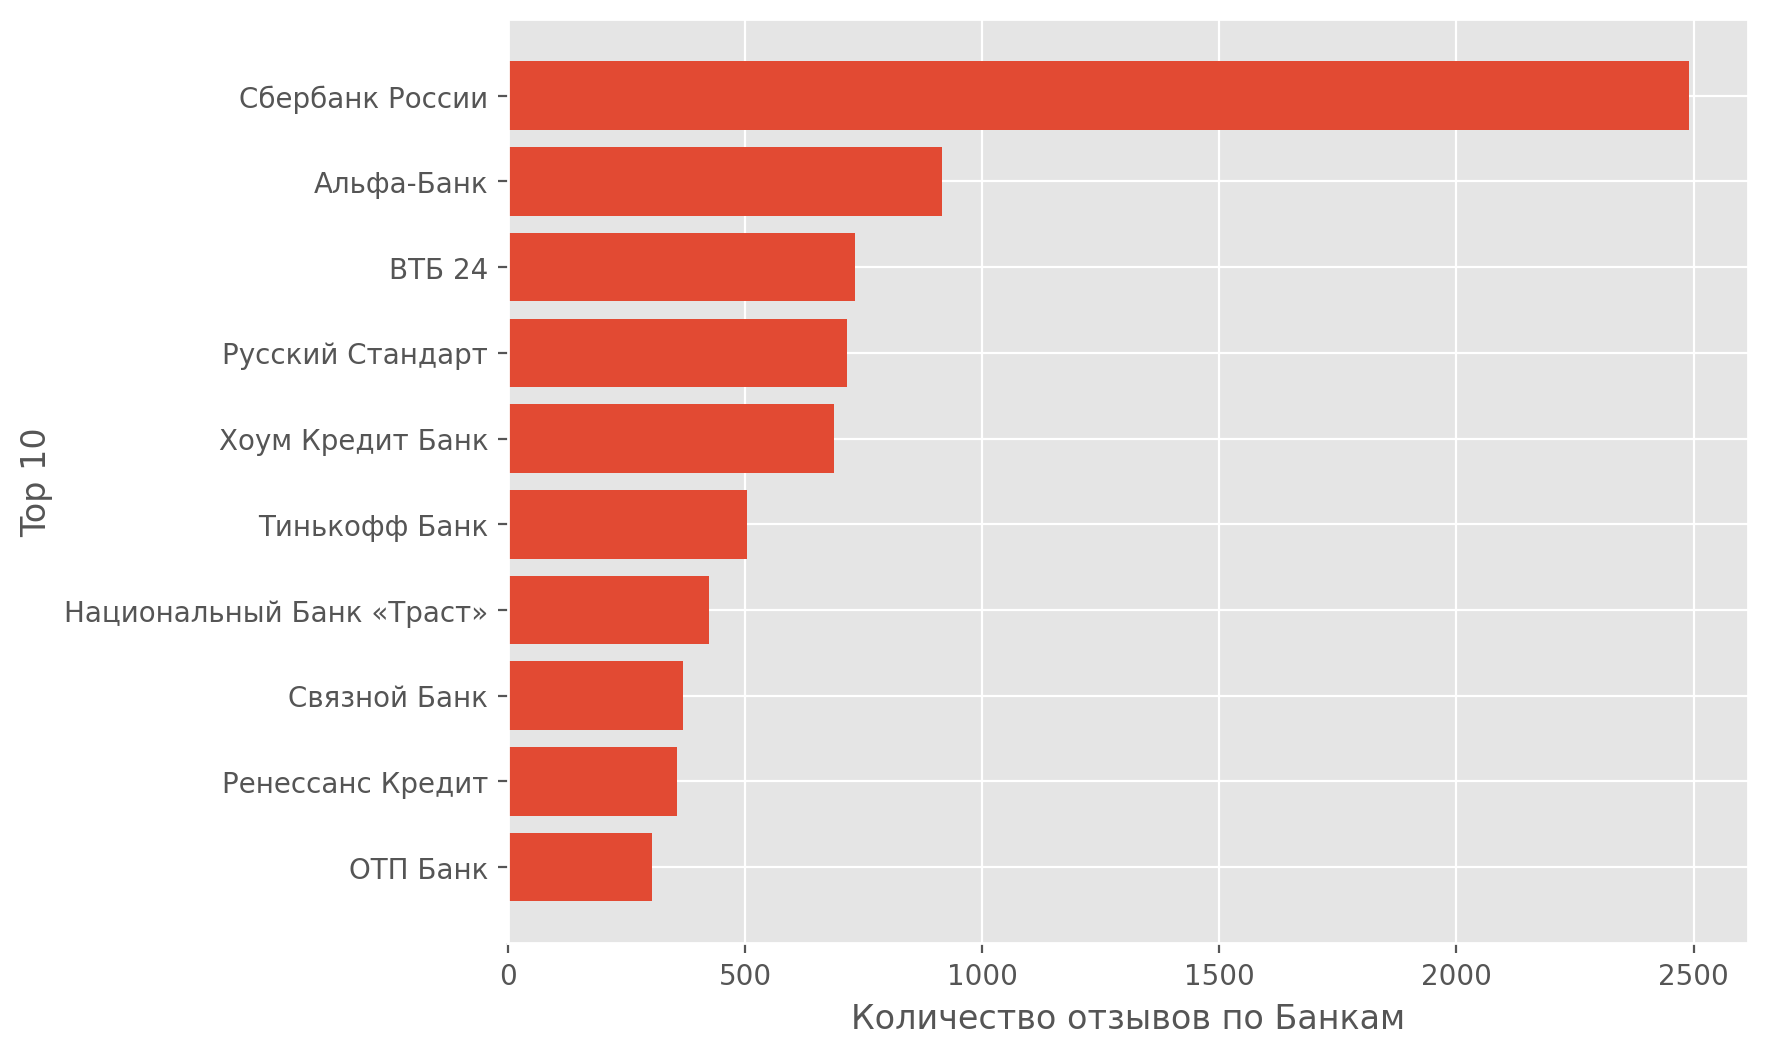

In [18]:
banks = df_notna.groupby(['bank_name']).count()['text'].sort_values(ascending=False).head(10)
rcParams['figure.figsize'] = 8, 6
plt.barh(banks.index[::-1],banks.values[::-1])
plt.xlabel('Количество отзывов по Банкам')
plt.ylabel('Top 10')
plt.show()

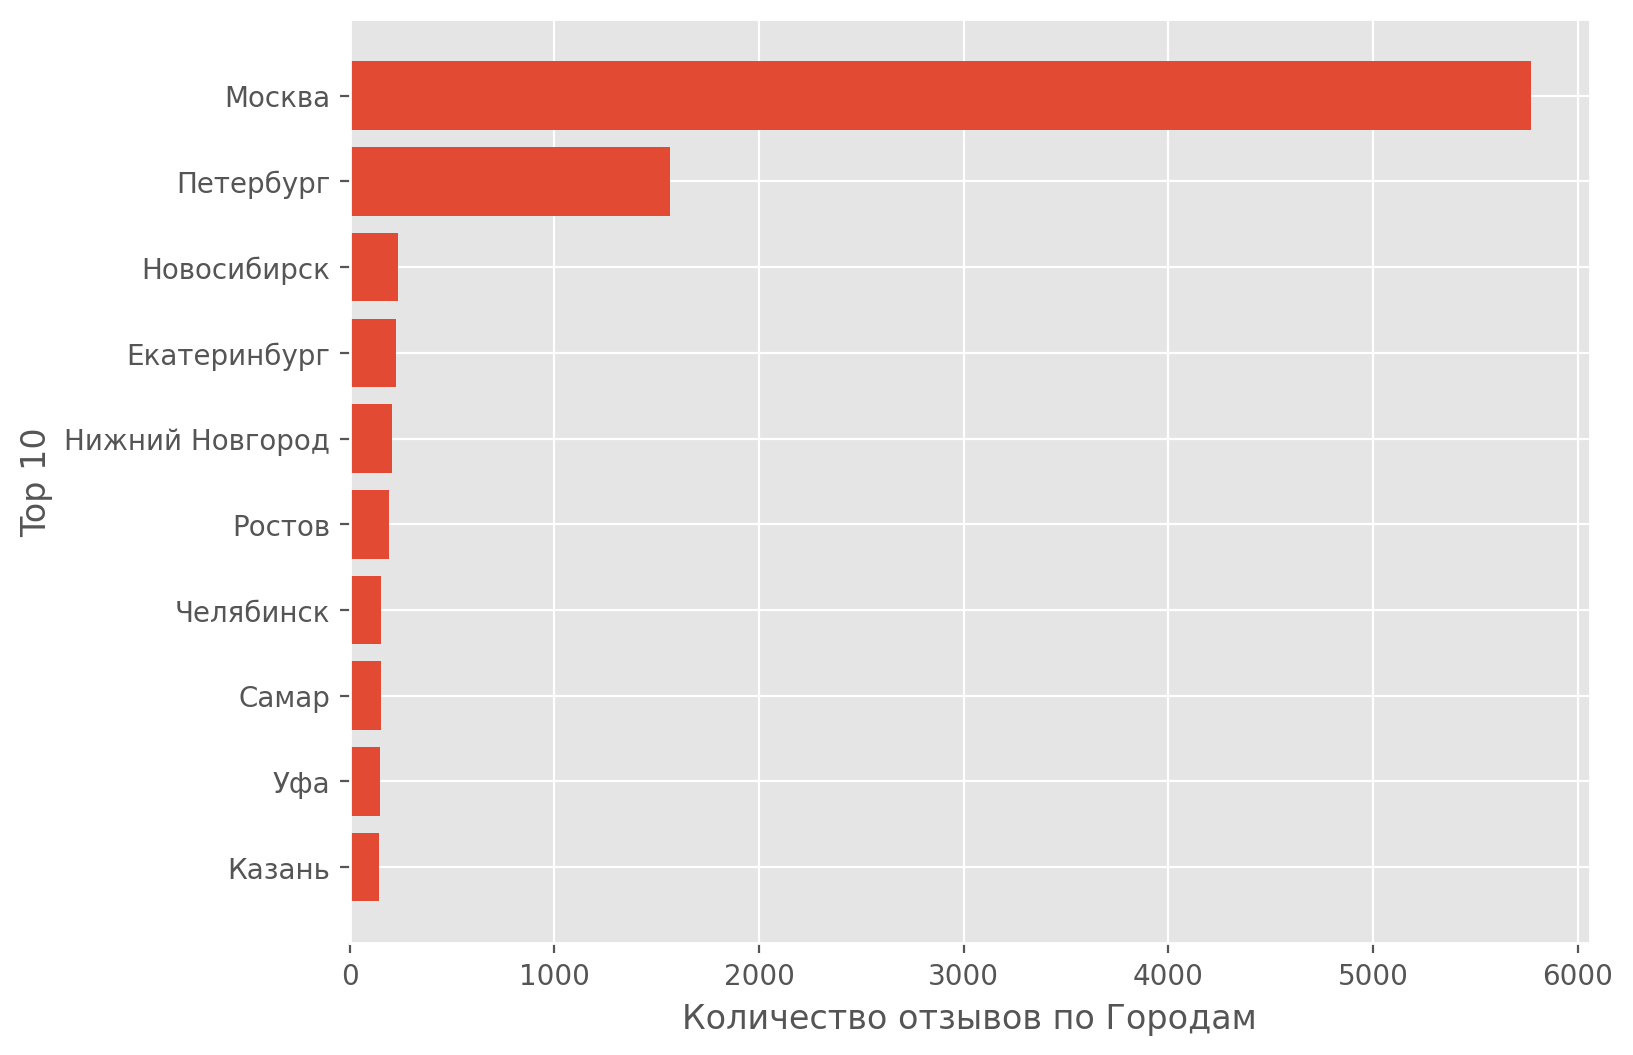

In [19]:
cities = df_notna.groupby(['clean_city']).count()['text'].sort_values(ascending=False).head(10)
rcParams['figure.figsize'] = 8, 6
plt.barh(cities.index[::-1],cities.values[::-1])
plt.xlabel('Количество отзывов по Городам')
plt.ylabel('Top 10')
plt.show()

Москва и Питер очевидно встречаются чаще чем другие данные

### 2. Постройте гистограмм длин слов

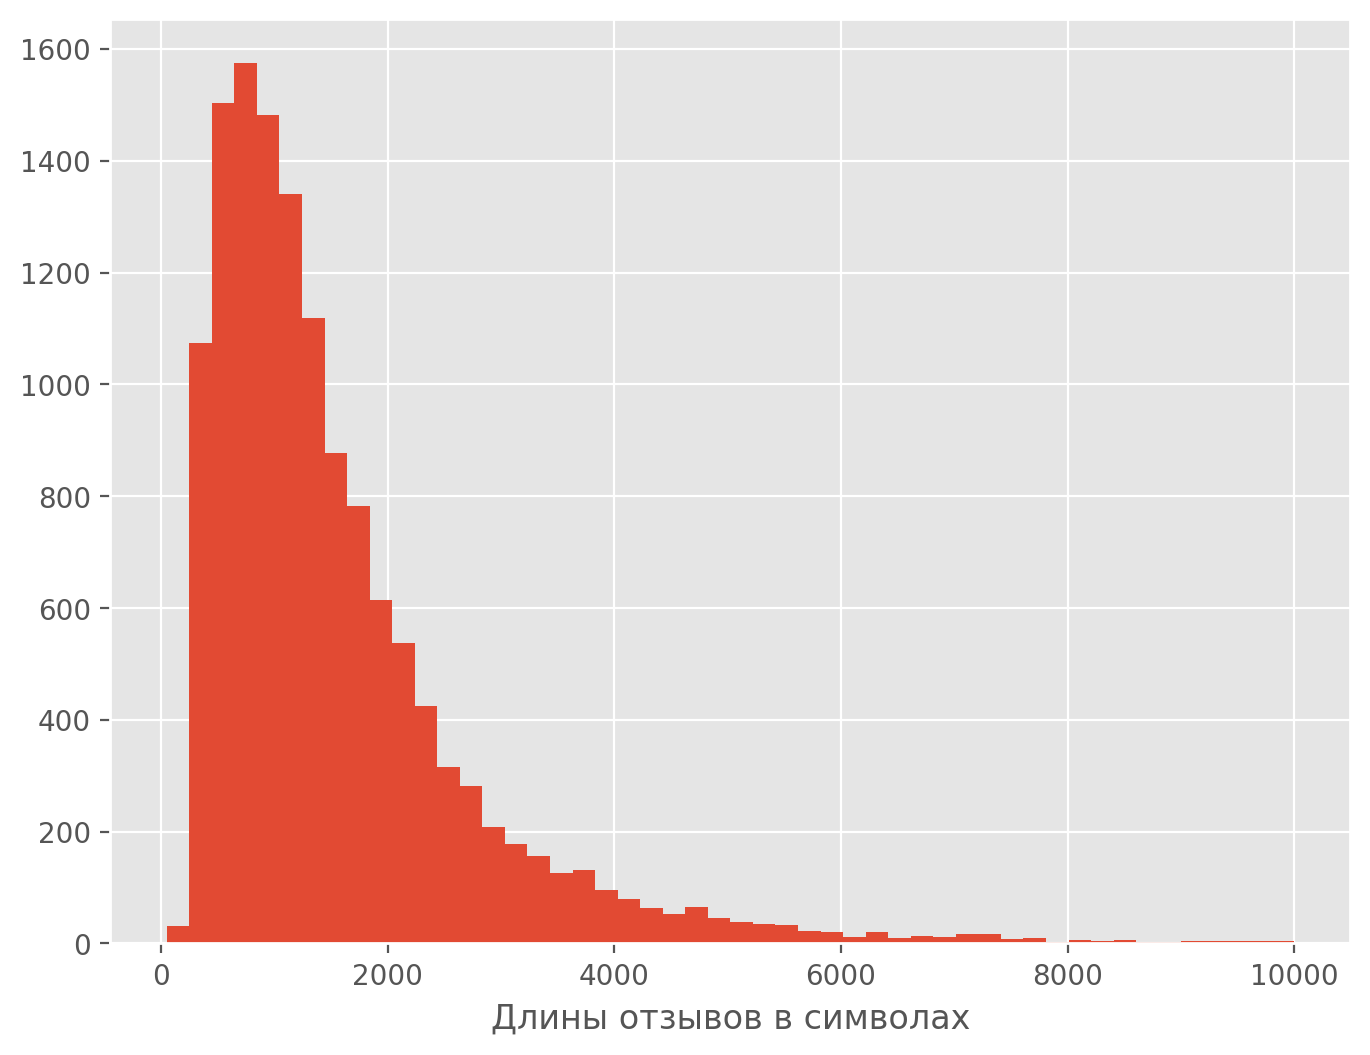

In [20]:
len_c = df_notna.text.apply(len)
rcParams['figure.figsize'] = 8, 6
len_c[len_c<10000].plot(kind='hist',bins=50)
plt.xlabel('Длины отзывов в символах')
plt.ylabel('')
plt.show()

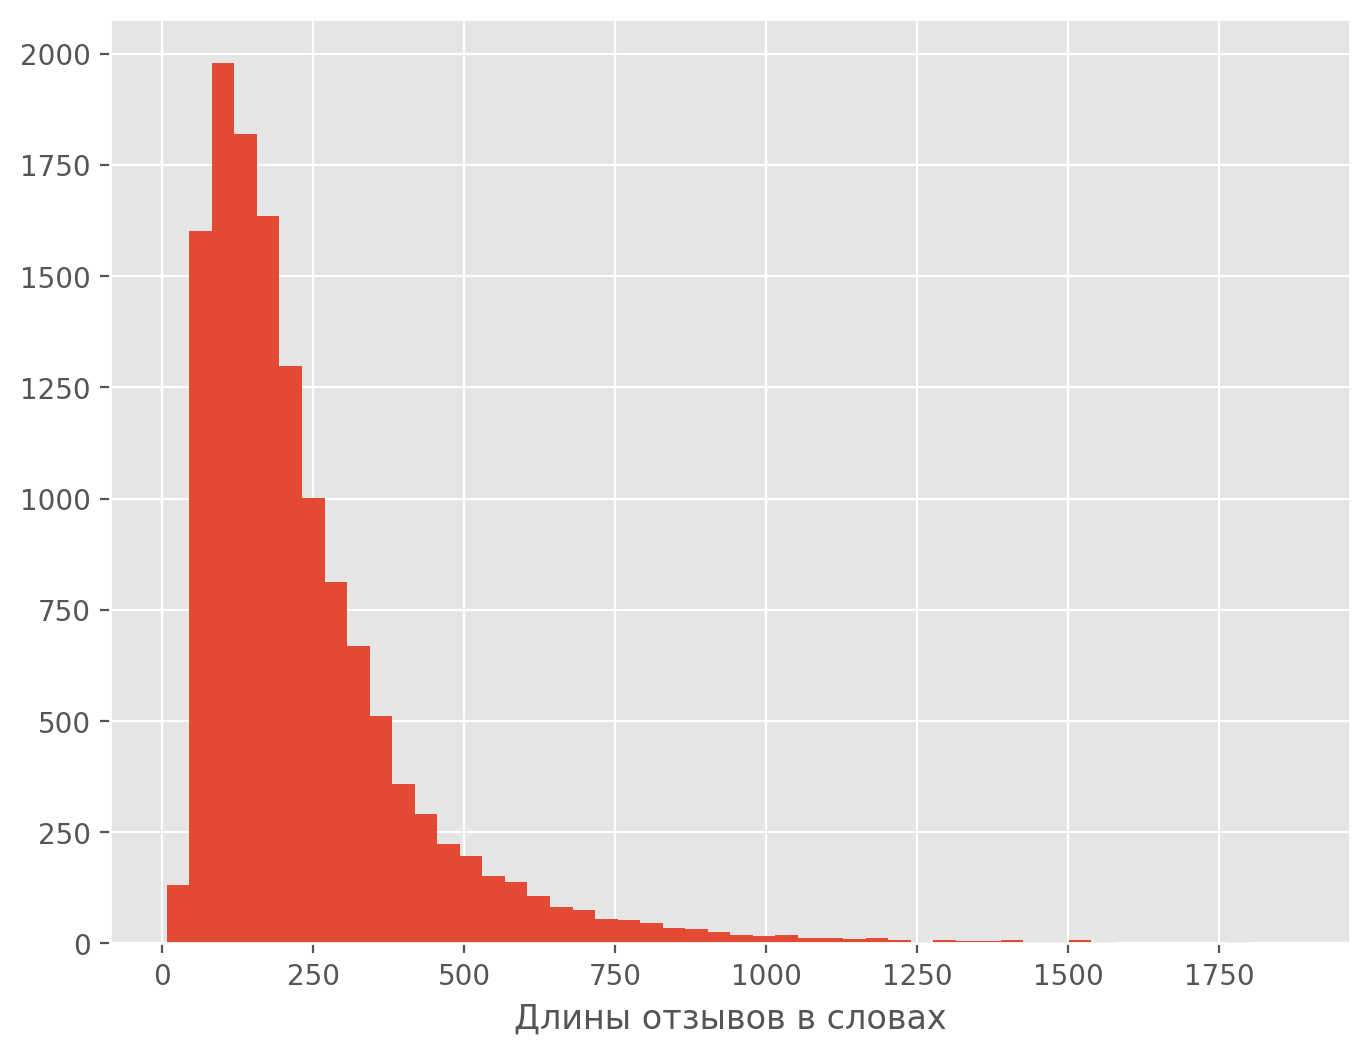

In [21]:
len_t = df_notna.text.str.split().apply(len)
rcParams['figure.figsize'] = 8, 6
len_t[len_t<2000].plot(kind='hist',bins=50)
plt.xlabel('Длины отзывов в словах')
plt.ylabel('')
plt.show()

### 3. Найдите 10 самых частых:
- слов
- слов без стоп-слов
- лемм
- существительных

#### Слова

In [22]:
regex = re.compile("[А-Яа-я]+")

def words_only(text, regex=regex):
    try:
        return " ".join(regex.findall(text))
    except:
        return ""

In [23]:
df = df_notna.copy()
df['text_tokinized'] =  df.text.str.lower().apply(words_only)

In [24]:
from tqdm import tqdm_notebook as tqdm
from collections import Counter

cnt = Counter()
n_types = []
n_tokens = []
tokens = []

for index, row in tqdm(df.iterrows(), total = len(df)):
    tokens = row['text_tokinized'].split()
    cnt.update(tokens)
    n_types.append(len(cnt))
    n_tokens.append(sum(list(cnt.values())))

for i in cnt.most_common(10):
    print(i)

  0%|          | 0/13500 [00:00<?, ?it/s]

('в', 117887)
('и', 94058)
('не', 76413)
('на', 62778)
('что', 57285)
('я', 51610)
('с', 41430)
('по', 33484)
('мне', 28931)
('банка', 24550)


#### Cлова без стоп-слов

In [25]:
from nltk.corpus import stopwords
# import nltk
# nltk.download('stopwords')

mystopwords = stopwords.words('russian') + ['это', 'наш' , 'тыс', 'млн', 'млрд', 'также', 'т', 'д', 'г']
def remove_stopwords(text, mystopwords=mystopwords):
    try:
        return " ".join([token for token in text.split() if not token in mystopwords])
    except:
        return ""

In [26]:
df['text_tokinized_stop_worlds'] = df.text_tokinized.str.lower().apply(remove_stopwords)

In [27]:
df.head(3)

,city,rating_not_checked,title,num_comments,bank_license,author,bank_name,datetime,text,rating_grade,clean_city,text_tokinized,text_tokinized_stop_worlds
39937,г. Москва,False,Два года безуспешно пытаюсь перейти в НПФ Сбер...,0,лицензия № 1481,l22,Сбербанк России,2014-07-22 12:58:00,Два года безуспешно пытаюсь перейти в НПФ Сбер...,1.0,Москва,два года безуспешно пытаюсь перейти в нпф сбер...,года безуспешно пытаюсь перейти нпф сбербанка ...
46909,г. Нижневартовск,False,Прошу разобраться в закрытии моих счетов ранее...,0,лицензия № 2766,sh.tatiana71,ОТП Банк,2014-05-22 10:57:00,Прошу вас закрыть по кредитным договорам №1871...,NaN,Нижневартовск,прошу вас закрыть по кредитным договорам и на ...,прошу закрыть кредитным договорам общению сумм...
66909,г. Москва,False,Договор о сотрудничестве с застройщиком,0,лицензия № 1481,katybv86,Сбербанк России,2013-11-21 12:39:00,"Добрый день. Хотела бы узнать у Сбербанка, ск...",NaN,Москва,добрый день хотела бы узнать у сбербанка сколь...,добрый день хотела узнать сбербанка сколько ва...


In [28]:
cnt = Counter()
n_types = []
n_tokens = []
tokens = []
tokens_all=[]

for index, row in tqdm(df.iterrows(), total = len(df)):
    tokens = row['text_tokinized_stop_worlds'].split()
    tokens_all+=tokens
    cnt.update(tokens)
    n_types.append(len(cnt))
    n_tokens.append(sum(cnt.values()))
    
for i in cnt.most_common(10):
    print(i)

  0%|          | 0/13500 [00:00<?, ?it/s]

('банка', 24550)
('банк', 19322)
('деньги', 11584)
('карту', 9816)
('карты', 9567)
('кредит', 7188)
('день', 6978)
('заявление', 6547)
('банке', 6362)
('время', 5882)


Без использования Лемм одинаковые по смыслу слова считаются не корректно

#### Использование Леммы

In [29]:
from pymorphy2 import MorphAnalyzer
from pymystem3 import Mystem

In [30]:
m = Mystem()
def lemmatize(text, mystem=m):
    try:
        return "".join(m.lemmatize(text)).strip()  
    except:
        return " "

In [31]:
mystoplemmas = stopwords.words('russian') + ['который','прошлый','сей', 'свой', 'наш', 'мочь', 'г']

def remove_stoplemmas(text, mystoplemmas=mystoplemmas):
    try:
        return " ".join([token for token in text.split() if not token in mystoplemmas])
    except:
        return ""

In [32]:
df['lemma'] = df['text_tokinized_stop_worlds'].apply(lemmatize)

In [36]:
### до него оставил на запуске, после продолжить
df.size

1918

In [33]:
df['lemma']

39937     год безуспешно пытаться переходить нпф сбербан...
46909     просить закрывать кредитный договор общение су...
66909     добрый день хотеть узнавать сбербанк сколько в...
5923      уважаемый господин отвечать пожалуйста видеть ...
99106     год взять ипотечный кредит аба финанс банк реш...
                                ...                        
120697    сегодня утро отправлять перевод денежный средс...
55150     пользоваться альфа клик оплата мобильный интер...
22798     сегодня банкомат списывать деньги выдавать сум...
44641     написать надеяться ответ сотрудник банк помощь...
17982     октябрь год утерять украсть паспорт оформлять ...
Name: lemma, Length: 13500, dtype: object

In [34]:
df.head(3)

,city,rating_not_checked,title,num_comments,bank_license,author,bank_name,datetime,text,rating_grade,clean_city,text_tokinized,text_tokinized_stop_worlds,lemma
39937,г. Москва,False,Два года безуспешно пытаюсь перейти в НПФ Сбер...,0,лицензия № 1481,l22,Сбербанк России,2014-07-22 12:58:00,Два года безуспешно пытаюсь перейти в НПФ Сбер...,1.0,Москва,два года безуспешно пытаюсь перейти в нпф сбер...,года безуспешно пытаюсь перейти нпф сбербанка ...,год безуспешно пытаться переходить нпф сбербан...
46909,г. Нижневартовск,False,Прошу разобраться в закрытии моих счетов ранее...,0,лицензия № 2766,sh.tatiana71,ОТП Банк,2014-05-22 10:57:00,Прошу вас закрыть по кредитным договорам №1871...,NaN,Нижневартовск,прошу вас закрыть по кредитным договорам и на ...,прошу закрыть кредитным договорам общению сумм...,просить закрывать кредитный договор общение су...
66909,г. Москва,False,Договор о сотрудничестве с застройщиком,0,лицензия № 1481,katybv86,Сбербанк России,2013-11-21 12:39:00,"Добрый день. Хотела бы узнать у Сбербанка, ск...",NaN,Москва,добрый день хотела бы узнать у сбербанка сколь...,добрый день хотела узнать сбербанка сколько ва...,добрый день хотеть узнавать сбербанк сколько в...


In [35]:
cnt = Counter()
n_types = []
n_tokens = []
tokens = []
tokens_all=[]

for index, row in tqdm(df.iterrows(), total = len(df)):
    tokens = row['lemma'].split()
    cnt.update(tokens)
    n_types.append(len(cnt))
    tokens_all+=tokens
    n_tokens.append(sum(list(cnt.values())))
    
for i in cnt.most_common(10):
    print(i)

  0%|          | 0/13500 [00:00<?, ?it/s]

('банк', 55319)
('карта', 30968)
('деньги', 15813)
('день', 15533)
('мой', 14763)
('кредит', 13875)
('который', 13440)
('отделение', 12525)
('клиент', 12080)
('сотрудник', 12053)


#### Существительные

In [36]:
m=MorphAnalyzer()
def to_nouns(text, mystem=m):
    try:
        return " ".join([noun for noun in text.split() if m.parse(noun)[0].tag.POS =='NOUN'])
    except:
        return []

to_nouns(df.lemma.iloc[2])

'день сбербанк время банк застройщик компания неделя вопрос банк отделение ипотека покупка жилье неделя мочь сбербанк конец год неделя расчет россия бумага'

In [37]:
df['nouns'] = df['lemma'].apply(to_nouns)

In [98]:
from multiprocessing import Pool

with Pool() as p:
    df['nouns']=p.map(to_nouns,df.lemma)

In [38]:
cnt_noun = Counter()
n_types_noun = []
n_tokens_noun= []
tokens_noun = []
tokens_all_noun=[]

for index, row in tqdm(df.iterrows(), total = len(df)):
    tokens = row['nouns'].split()
    cnt_noun.update(tokens)
    n_types_noun.append(len(cnt))
    tokens_all_noun+=tokens
    n_tokens_noun.append(sum(cnt.values()))

for i in cnt_noun.most_common(10):
    print(i)

  0%|          | 0/13500 [00:00<?, ?it/s]

('банк', 55319)
('карта', 30968)
('деньги', 15813)
('день', 15533)
('кредит', 13875)
('отделение', 12525)
('клиент', 12080)
('сотрудник', 12053)
('счет', 11382)
('сумма', 10137)


### 4. Кривая Ципфа

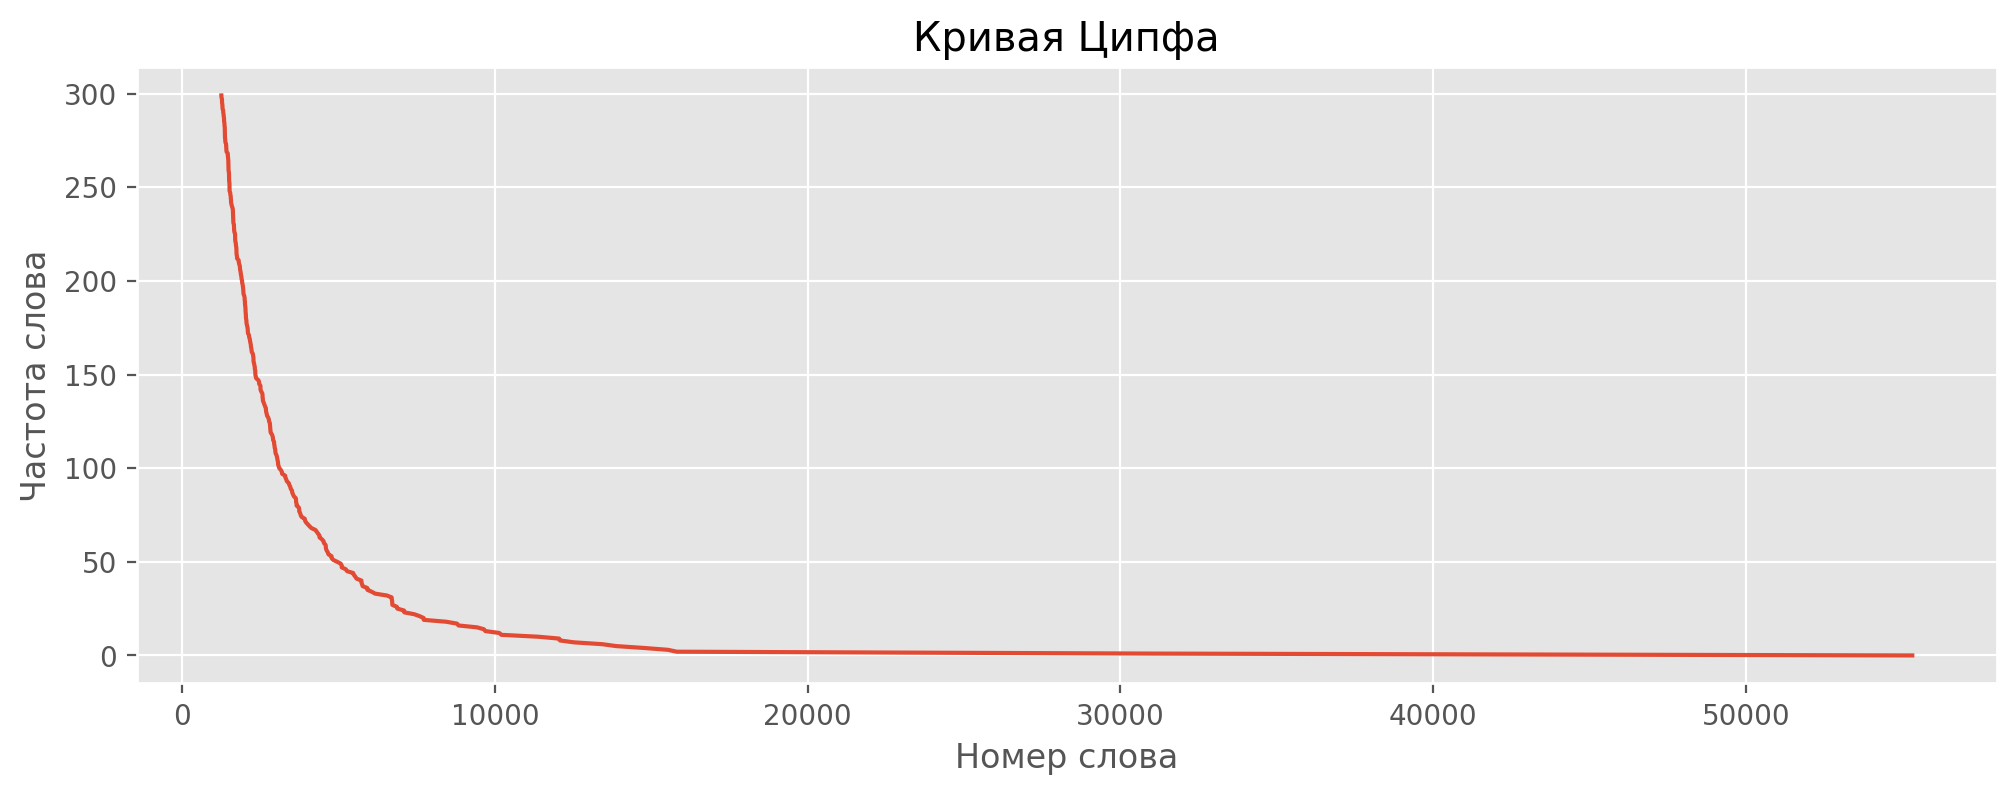

In [39]:
freqs = list(cnt.values())
freqs = sorted(freqs, reverse = True)

fig, ax = plt.subplots(figsize=(12,4))
ax.plot(freqs[:300], range(300))
plt.xlabel('Номер слова')
plt.ylabel('Частота слова')
plt.title('Кривая Ципфа')
plt.show()

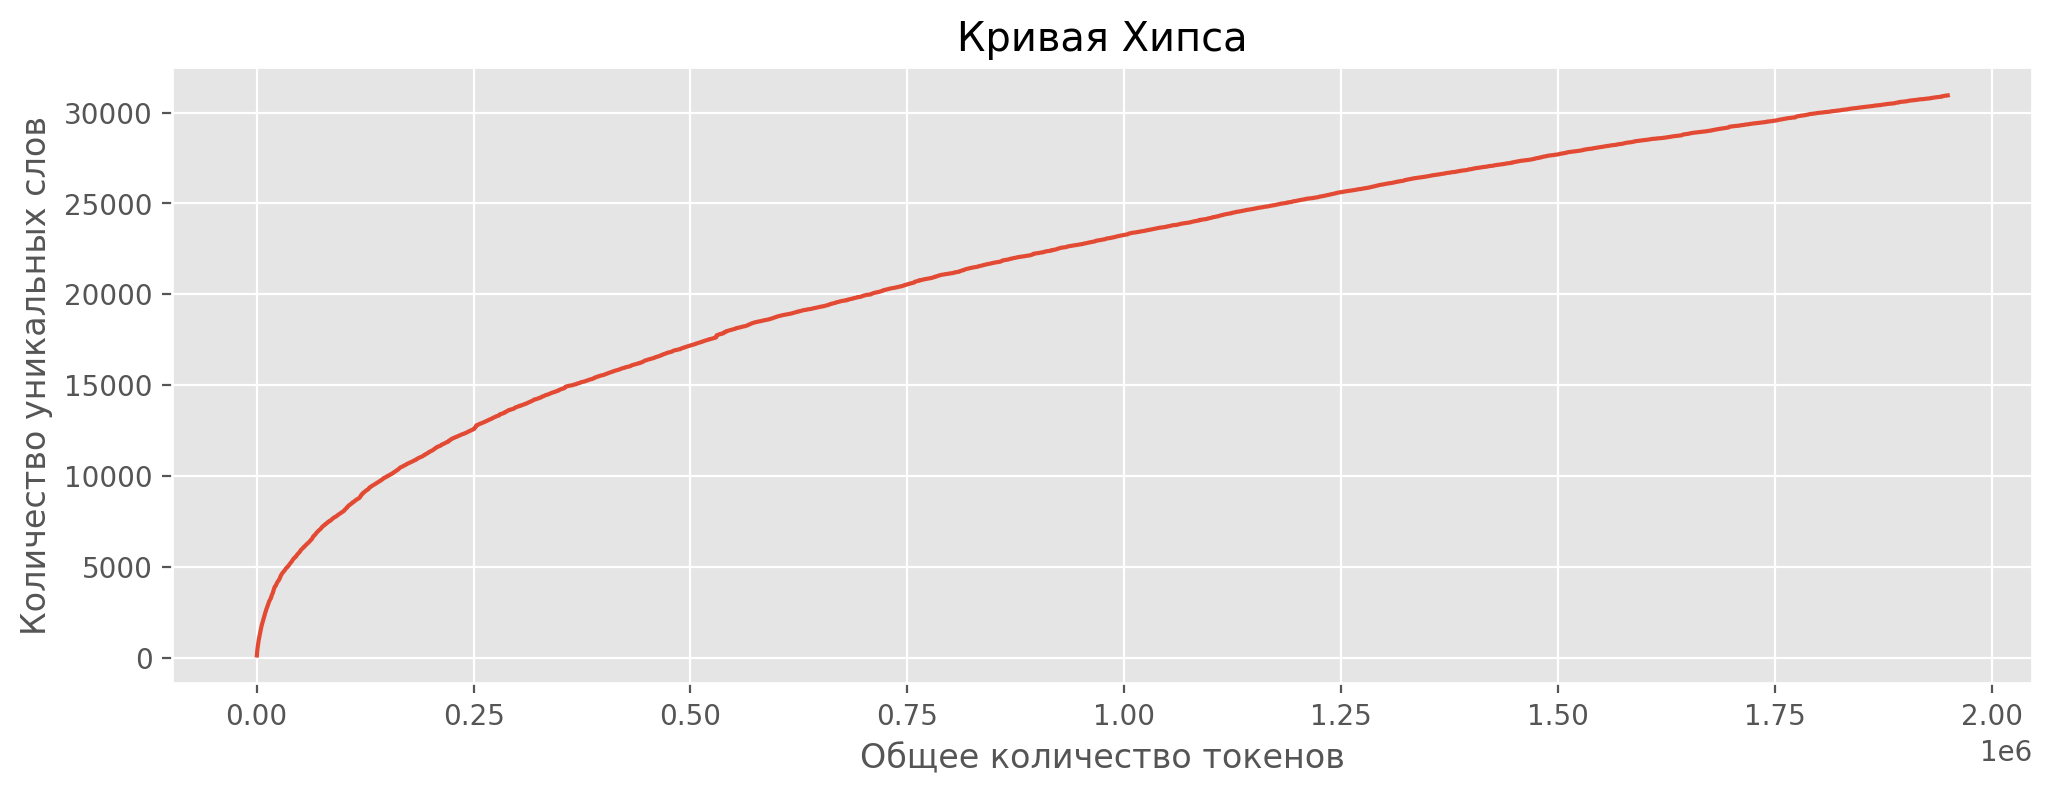

In [40]:
fig, ax = plt.subplots(figsize=(12, 4))
ax.plot(n_tokens, n_types)
plt.xlabel('Общее количество токенов')
plt.ylabel('Количество уникальных слов')
plt.title('Кривая Хипса')
plt.show()

### 5. какое слово встречается чаще, "сотрудник" или "клиент"? / сколько раз встречается слова "мошенничество" и "доверие"?

In [54]:
from nltk import FreqDist
Freq_Dist = FreqDist(tokens_all)

In [57]:
print('Слово "сотрудник" встречается -"',Freq_Dist['сотрудник'],'раз')
print('Слово "клиент" встречается -"',Freq_Dist['клиент'],'раз')

Слово "сотрудник" встречается -" 122619 раз
Слово "клиент" встречается -" 121659 раз


"клиент" чаще "сотрудник"

In [58]:
print('Слово "мошенничество" встречается -"',Freq_Dist['мошенничество'],'раз')
print('Слово "доверие" встречается -"',Freq_Dist['доверие'],'раз')

Слово "мошенничество" встречается -" 3046 раз
Слово "доверие" встречается -" 1884 раз


"мошенничество" чаще "доверие"

### 6. Использование `𝑡𝑓−𝑖𝑑𝑓` , для поиска ключевых слова и баграмы (положительных отзывов (5) и отрицательных отзывов (1))

In [64]:
df['rating_grade'].value_counts()

1.0    39026
2.0    12995
5.0    10273
3.0     7362
4.0     3495
Name: rating_grade, dtype: int64

In [65]:
num=10000

df_sample = df[(df.rating_grade==1)].sample(n=num).copy()
df_sample = df_sample.append(df[(df.rating_grade==5)].sample(n=num))

df_sample.rating_grade.value_counts()

5.0    10000
1.0    10000
Name: rating_grade, dtype: int64

In [66]:
tokens_by_topic = []

for rating in df_sample.rating_grade.unique():
    tokens=[]
    sample=df_sample[df_sample['rating_grade']==rating]
    
    for i in range(len(sample)):
        tokens += sample.lemma.iloc[i].split()
        
    tokens_by_topic.append(tokens)

In [68]:
df_sample.head(3)

,author,bank_license,bank_name,city,datetime,num_comments,rating_grade,rating_not_checked,text,title,clean_city,text_tokinized,text_tokinized_stop_worlds,lemma,nouns
119921,andrey_egorov,лицензия № 3292,Райффайзенбанк,г. Санкт-Петербург,2011-09-02 15:42:00,6,1.0,False,Прошу отдел качества максимально внимательно о...,"""Мы заблокировали, но почему - не знаем!""",Петербург,прошу отдел качества максимально внимательно о...,прошу отдел качества максимально внимательно о...,просить отдел качество максимально внимательно...,отдел качество обращение обращение банк август...
89328,*Galina*,лицензия № 1623,ВТБ 24,г. Новосибирск,2013-03-04 09:21:00,1,1.0,False,Подала заявку на получение потребительского кр...,Отвратительное обслуживание,Новосибирск,подала заявку на получение потребительского кр...,подала заявку получение потребительского креди...,подавать заявка получение потребительский кред...,заявка получение кредит интернет москва анкета...
48436,Не клиентkzn,лицензия № 3279,Национальный Банк «Траст»,г. Казань,2014-05-05 19:21:00,2,1.0,False,Согласна со всеми раннее оставленными отзывами...,Звонки из банка,Казань,согласна со всеми раннее оставленными отзывами...,согласна всеми раннее оставленными отзывами не...,согласный все ранний оставлять отзыв некомпете...,согласный отзыв работа сотрудник центр дирекци...


#### Использование униграмм

In [69]:
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np

tfidf = TfidfVectorizer(analyzer='word', ngram_range=(1,1), min_df = 0)
tfidf_matrix =  tfidf.fit_transform([' '.join(tokens) for tokens in tokens_by_topic])
feature_names = tfidf.get_feature_names() 
tfidf_ranking_5 = []
tfidf_ranking_1 = []
dense = tfidf_matrix.todense()

text = dense[1].tolist()[0]
phrase_scores = [pair for pair in zip(range(0, len(text)), text) if pair[1] > 0]
sorted_phrase_scores = sorted(phrase_scores, key=lambda t: t[1] * -1)
phrases = []

for phrase, score in [(feature_names[word_id], score) for (word_id, score) in sorted_phrase_scores][:70]:
    tfidf_ranking_5.append(phrase)
    
text = dense[0].tolist()[0]
phrase_scores = [pair for pair in zip(range(0, len(text)), text) if pair[1] > 0]
sorted_phrase_scores = sorted(phrase_scores, key=lambda t: t[1] * -1)
phrases = []

for phrase, score in [(feature_names[word_id], score) for (word_id, score) in sorted_phrase_scores][:70]:
    tfidf_ranking_1.append(phrase)

In [70]:
rank = pd.DataFrame({'tfidf_ranking_5': tfidf_ranking_5,'tfidf_ranking_1': tfidf_ranking_1})
rank.head(10)

,tfidf_ranking_5,tfidf_ranking_1
0,банк,банк
1,карта,карта
2,очень,деньги
3,клиент,день
4,день,мой
5,сотрудник,отделение
6,кредит,сотрудник
7,который,который
8,отделение,кредит
9,вклад,счет


Исключение пересечений

In [73]:
rank['tfidf_ranking_5_without_1']=rank.tfidf_ranking_5[~rank.tfidf_ranking_5.isin(rank.tfidf_ranking_1)]
rank['tfidf_ranking_1_without_5']=rank.tfidf_ranking_1[~rank.tfidf_ranking_1.isin(rank.tfidf_ranking_5)]

In [78]:
rank.iloc[:,-2:].dropna()

,tfidf_ranking_5_without_1,tfidf_ranking_1_without_5
20,обслуживание,ответ
30,быстро,номер
32,интернет,написать
36,банка,ваш
38,очередь,средство
39,открывать,отвечать
45,хороший,звонок
59,самый,операция
63,помогать,давать
67,вс,знать


#### Использование биграмм

In [79]:
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np

tfidf = TfidfVectorizer(analyzer='word', ngram_range=(2,2), min_df = 0)
tfidf_matrix =  tfidf.fit_transform([' '.join(tokens) for tokens in tokens_by_topic])
feature_names = tfidf.get_feature_names() 
tfidf_ranking_rank_is_5 = []
tfidf_ranking_rank_is_1 = []
dense = tfidf_matrix.todense()

text = dense[1].tolist()[0]
phrase_scores = [pair for pair in zip(range(0, len(text)), text) if pair[1] > 0]
sorted_phrase_scores = sorted(phrase_scores, key=lambda t: t[1] * -1)
phrases = []

for phrase, score in [(feature_names[word_id], score) for (word_id, score) in sorted_phrase_scores][:70]:
    tfidf_ranking_rank_is_5.append(phrase)
    
text = dense[0].tolist()[0]
phrase_scores = [pair for pair in zip(range(0, len(text)), text) if pair[1] > 0]
sorted_phrase_scores = sorted(phrase_scores, key=lambda t: t[1] * -1)
phrases = []

for phrase, score in [(feature_names[word_id], score) for (word_id, score) in sorted_phrase_scores][:70]:
    tfidf_ranking_rank_is_1.append(phrase) 

In [81]:
rankings = pd.DataFrame({'tfidf_ranking_rank_is_5': tfidf_ranking_rank_is_5,'tfidf_ranking_rank_is_1': tfidf_ranking_rank_is_1})
rankings.head(10)

,tfidf_ranking_rank_is_5,tfidf_ranking_rank_is_1
0,интернет банк,сотрудник банк
1,другой банк,денежный средство
2,сотрудник банк,отделение банк
3,кредитный карта,кредитный карта
4,клиент банк,написать заявление
5,открывать вклад,горячий линия
6,отделение банк,колл центр
7,являться клиент,рабочий день
8,следующий день,интернет банк
9,добрый день,служба поддержка


In [82]:
rankings['tfidf_ranking_rank_is_5_without_1']=rankings.tfidf_ranking_rank_is_5[~rankings.tfidf_ranking_rank_is_5.isin(rankings.tfidf_ranking_rank_is_1)]
rankings['tfidf_ranking_rank_is_1_without_5']=rankings.tfidf_ranking_rank_is_1[~rankings.tfidf_ranking_rank_is_1.isin(rankings.tfidf_ranking_rank_is_5)]

In [83]:
rankings.iloc[:,-2:].dropna()

,tfidf_ranking_rank_is_5_without_1,tfidf_ranking_rank_is_1_without_5
13,выражать благодарность,сей пора
19,приятно удивлять,получать ответ
22,банк очень,писать заявление
24,год назад,течение день
25,очень довольный,номер телефон
26,мой вопрос,обращаться отделение
30,большой спасибо,мой заявление
34,огромный спасибо,мой деньги
36,услуга банк,снимать деньги
37,банк москва,погашение кредит


## Тематическое моделирование

In [86]:
import gensim.corpora as corpora
from gensim.models import ldamodel

In [87]:
texts = [df['lemma'].iloc[i].split() for i in range(len(df))]
dictionary = corpora.Dictionary(texts)
corpus = [dictionary.doc2bow(text) for text in texts]

In [88]:
import random
random.seed(11)

In [89]:
lda = ldamodel.LdaModel(corpus=corpus, 
                        id2word=dictionary, 
                        num_topics=20, 
                        alpha='auto', 
                        eta='auto', 
                        iterations = 20, 
                        passes = 5)

In [90]:
# 20 тем, рандомная выборка 5
lda.show_topics(5)

[(15,
  '0.067*"рубль" + 0.052*"курс" + 0.046*"доллар" + 0.045*"валюта" + 0.045*"евро" + 0.038*"комиссия" + 0.037*"сумма" + 0.032*"кассир" + 0.020*"валютный" + 0.019*"касса"'),
 (5,
  '0.048*"лимит" + 0.030*"связной" + 0.030*"покупка" + 0.025*"магазин" + 0.023*"акция" + 0.022*"период" + 0.022*"кредитный" + 0.021*"ткс" + 0.017*"карта" + 0.017*"балл"'),
 (2,
  '0.042*"день" + 0.031*"банк" + 0.027*"позвонить" + 0.021*"звонить" + 0.018*"сказать" + 0.015*"телефон" + 0.014*"центр" + 0.014*"заявка" + 0.013*"звонок" + 0.013*"вопрос"'),
 (19,
  '0.016*"сказать" + 0.015*"говорить" + 0.015*"девушка" + 0.012*"приходить" + 0.012*"деньги" + 0.011*"вс" + 0.009*"знать" + 0.009*"спрашивать" + 0.008*"думать" + 0.008*"давать"'),
 (13,
  '0.060*"банк" + 0.022*"клиент" + 0.012*"который" + 0.010*"свой" + 0.009*"год" + 0.009*"такой" + 0.008*"другой" + 0.007*"проблема" + 0.007*"время" + 0.007*"один"')]

1. Обмен
2. Покупка по акции, что-то связанное c картами
3. Заявка в поддержку
4. Консультации
5. Проблема постоянного клиента

In [91]:
lda15 = ldamodel.LdaModel(corpus=corpus, 
                          id2word=dictionary, 
                          num_topics=15, 
                          alpha='auto', 
                          eta='auto', 
                          iterations = 20, 
                          passes = 5)

In [92]:
# 25 тем, рандомная выборка 5
lda15.show_topics(5)

[(8,
  '0.131*"вклад" + 0.039*"открывать" + 0.037*"банк" + 0.027*"депозит" + 0.026*"процент" + 0.020*"деньги" + 0.020*"договор" + 0.017*"офис" + 0.014*"сумма" + 0.014*"ставка"'),
 (9,
  '0.078*"кредит" + 0.023*"банк" + 0.017*"кредитный" + 0.017*"документ" + 0.015*"договор" + 0.015*"оформлять" + 0.015*"заявка" + 0.014*"страховка" + 0.011*"квартира" + 0.011*"сумма"'),
 (12,
  '0.019*"отделение" + 0.016*"очередь" + 0.013*"работать" + 0.012*"минута" + 0.010*"человек" + 0.010*"девушка" + 0.009*"офис" + 0.008*"касса" + 0.008*"час" + 0.008*"клиент"'),
 (4,
  '0.030*"день" + 0.029*"банк" + 0.020*"сказать" + 0.019*"позвонить" + 0.015*"звонить" + 0.014*"ответ" + 0.013*"вопрос" + 0.012*"отделение" + 0.011*"отвечать" + 0.010*"телефон"'),
 (10,
  '0.054*"банк" + 0.021*"клиент" + 0.016*"очень" + 0.009*"который" + 0.009*"свой" + 0.009*"работа" + 0.009*"время" + 0.009*"сотрудник" + 0.008*"вопрос" + 0.008*"год"')]

1. Открытие депозита
2. Кредит, страховка, квартира
3. Очередь
4. Звонок
5. Вопрос клиента сотруднику

In [93]:
lda10 = ldamodel.LdaModel(corpus=corpus, 
                          id2word=dictionary, 
                          num_topics=10, 
                          alpha='auto', 
                          eta='auto', 
                          iterations = 20, 
                          passes = 5)

In [100]:
# 10 тем
lda10.show_topics(5)

[(5,
  '0.051*"кредит" + 0.031*"документ" + 0.027*"банк" + 0.023*"заявка" + 0.016*"кредитный" + 0.013*"оформлять" + 0.012*"справка" + 0.012*"договор" + 0.010*"страховка" + 0.010*"менеджер"'),
 (0,
  '0.049*"вклад" + 0.043*"банк" + 0.026*"договор" + 0.021*"счет" + 0.015*"открывать" + 0.011*"условие" + 0.010*"процент" + 0.009*"документ" + 0.009*"клиент" + 0.008*"открытие"'),
 (2,
  '0.034*"деньги" + 0.030*"заявление" + 0.030*"банкомат" + 0.023*"сбербанк" + 0.021*"мой" + 0.018*"банк" + 0.018*"день" + 0.016*"карта" + 0.016*"претензия" + 0.015*"отделение"'),
 (4,
  '0.048*"банк" + 0.019*"клиент" + 0.014*"очень" + 0.009*"который" + 0.009*"свой" + 0.008*"работа" + 0.008*"год" + 0.007*"время" + 0.007*"вопрос" + 0.007*"сотрудник"'),
 (6,
  '0.020*"сказать" + 0.017*"день" + 0.015*"банк" + 0.012*"звонить" + 0.012*"позвонить" + 0.012*"говорить" + 0.010*"деньги" + 0.010*"мочь" + 0.009*"отвечать" + 0.009*"приходить"')]

1. Заявка на кредитный догово
2. Открытие вклада
3. Претензия клиента банку сбербанка
4. Вопрос в поддержку банка
5. Звонок клиента в банк

## Классификация текстов

In [2]:
# df_sample.to_csv('sample.csv', index=False)
# df_sample1 = pd.read_csv('/Users/aleksandr/Downloads/nlp-netology-master/sample.csv')
# df_sample1.head(3)
df_sample.head(3)

,author,bank_license,bank_name,city,datetime,num_comments,rating_grade,rating_not_checked,text,title,clean_city,text_tokinized,text_tokinized_stop_worlds,lemma,nouns
0,andrey_egorov,лицензия № 3292,Райффайзенбанк,г. Санкт-Петербург,2011-09-02 15:42:00,6,1.0,False,Прошу отдел качества максимально внимательно о...,"""Мы заблокировали, но почему - не знаем!""",Петербург,прошу отдел качества максимально внимательно о...,прошу отдел качества максимально внимательно о...,просить отдел качество максимально внимательно...,отдел качество обращение обращение банк август...
1,*Galina*,лицензия № 1623,ВТБ 24,г. Новосибирск,2013-03-04 09:21:00,1,1.0,False,Подала заявку на получение потребительского кр...,Отвратительное обслуживание,Новосибирск,подала заявку на получение потребительского кр...,подала заявку получение потребительского креди...,подавать заявка получение потребительский кред...,заявка получение кредит интернет москва анкета...
2,Не клиентkzn,лицензия № 3279,Национальный Банк «Траст»,г. Казань,2014-05-05 19:21:00,2,1.0,False,Согласна со всеми раннее оставленными отзывами...,Звонки из банка,Казань,согласна со всеми раннее оставленными отзывами...,согласна всеми раннее оставленными отзывами не...,согласный все ранний оставлять отзыв некомпете...,согласный отзыв работа сотрудник центр дирекци...


In [3]:
df_sample.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 15 columns):
author                        20000 non-null object
bank_license                  20000 non-null object
bank_name                     20000 non-null object
city                          20000 non-null object
datetime                      20000 non-null object
num_comments                  20000 non-null int64
rating_grade                  20000 non-null float64
rating_not_checked            20000 non-null bool
text                          20000 non-null object
title                         19854 non-null object
clean_city                    20000 non-null object
text_tokinized                20000 non-null object
text_tokinized_stop_worlds    20000 non-null object
lemma                         20000 non-null object
nouns                         20000 non-null object
dtypes: bool(1), float64(1), int64(1), object(12)
memory usage: 2.2+ MB


In [4]:
df_sample.rating_grade.value_counts()

5.0    10000
1.0    10000
Name: rating_grade, dtype: int64

In [5]:
df_sample.columns

Index(['author', 'bank_license', 'bank_name', 'city', 'datetime',
       'num_comments', 'rating_grade', 'rating_not_checked', 'text', 'title',
       'clean_city', 'text_tokinized', 'text_tokinized_stop_worlds', 'lemma',
       'nouns'],
      dtype='object')

In [99]:
X = df_sample['lemma'].values
y = df_sample.rating_grade.values

In [100]:
X.shape, y.shape

((20000,), (20000,))

In [6]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.feature_extraction import DictVectorizer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.decomposition import TruncatedSVD, LatentDirichletAllocation
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, classification_report, confusion_matrix

In [101]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [102]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((14000,), (6000,), (14000,), (6000,))

In [78]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier

#### Используйте любой известный вам алгоритм классификации текстов для решения задачи и получите baseline. Сравните разные варианты векторизации текста: использование только униграм, пар или троек слов или с использованием символьных  𝑛 -грам.

In [1]:
# from sklearn.pipeline import Pipeline
# from sklearn.ensemble import RandomForestClassifier

# !!! На каждом этапе Pipeline нужно указать свои параметры
# 1-ый вариант: tf-idf + LSI
# 2-ой вариант: LDA

# clf = Pipeline([
#     ('vect', CountVectorizer(analyzer = 'char', ngram_range={4,6})),
#     ('clf', RandomForestClassifier()),
# ])

# clf = Pipeline([ 
#     ('vect', CountVectorizer()), 
#     ('tfidf', TfidfTransformer()), 
#     ('tm', TruncatedSVD()), 
#     ('clf', RandomForestClassifier())
# ])

In [103]:
clf_countvectorized = Pipeline(
    [('vect', CountVectorizer()),
     ('clf', LogisticRegression())]
)

params_cntv = {
    'vect__analyzer': ['word','char'],
    'vect__max_df': (0.5, 0.75, 1.0),
    'vect__ngram_range': ((1, 1), (2, 2), (3, 3)),
    'clf__C': np.logspace(-3,3,7),
    'clf__penalty': ['l1','l2']  
}

scores=['accuracy', 'f1']

In [106]:
grid_cntv = GridSearchCV(
    clf_countvectorized, 
    param_grid=params_cntv, 
    cv=3,
    scoring=scores,
    refit=scores[0],
    n_jobs=-1, 
    verbose=1
)

In [107]:
grid_cntv.fit(X_train, y_train)

Fitting 3 folds for each of 252 candidates, totalling 756 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  3.3min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed: 13.9min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed: 34.1min
[Parallel(n_jobs=-1)]: Done 756 out of 756 | elapsed: 66.3min finished


GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('vect',
                                        CountVectorizer(analyzer='word',
                                                        binary=False,
                                                        decode_error='strict',
                                                        dtype=<class 'numpy.int64'>,
                                                        encoding='utf-8',
                                                        input='content',
                                                        lowercase=True,
                                                        max_df=1.0,
                                                        max_features=None,
                                                        min_df=1,
                                                        ngram_range=(1, 1),
                                            

In [115]:
# print(grid_cntv.best_estimator_)
print("Best score: %0.3f" % grid_cntv.best_score_)

Best score: 0.950


In [110]:
predictions=grid_cntv.best_estimator_.predict(X_test)

In [160]:
print("Precision: {0:6.2f}".format(precision_score(y_test, predictions, average='macro')))
print("Recall:    {0:6.2f}".format(recall_score(y_test, predictions, average='macro')))
print("F1_score:  {0:6.2f}".format(f1_score(y_test, predictions, average='macro')))
print("Accuracy:  {0:6.2f}".format(accuracy_score(y_test, predictions)))

Precision:   0.95
Recall:      0.95
F1_score:    0.95
Accuracy:    0.95


In [112]:
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

         1.0       0.94      0.95      0.95      2946
         5.0       0.96      0.94      0.95      3054

    accuracy                           0.95      6000
   macro avg       0.95      0.95      0.95      6000
weighted avg       0.95      0.95      0.95      6000



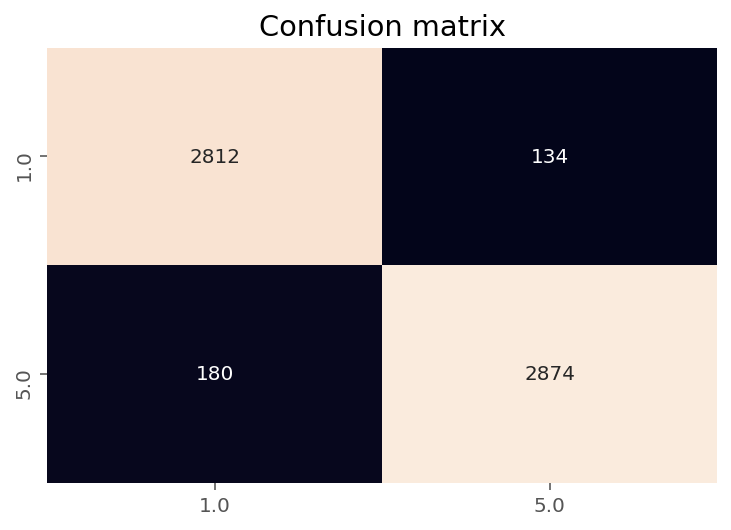

In [113]:
labels = grid_cntv.best_estimator_.classes_

sns.heatmap(
    data=confusion_matrix(y_test, predictions), 
    annot=True, 
    fmt="d", 
    cbar=False, 
    xticklabels=labels, 
    yticklabels=labels
)

plt.title("Confusion matrix")
plt.show()

#### Сравните, как изменяется качество решения задачи при использовании скрытых тем в качестве признаков:
- 1-ый вариант:  𝑡𝑓−𝑖𝑑𝑓  преобразование (sklearn.feature_extraction.text.TfidfTransformer) и сингулярное разложение (оно же – латентый семантический анализ) (sklearn.decomposition.TruncatedSVD),
- 2-ой вариант: тематические модели LDA (sklearn.decomposition.LatentDirichletAllocation).

Используйте accuracy и F-measure для оценки качества классификации. (Эта часть задания может быть сделана с использованием sklearn).

#### 1-ый вариант

𝑡𝑓−𝑖𝑑𝑓

In [117]:
clf_tf_idf = Pipeline(
    [('vect', CountVectorizer()),
     ('tfidf', TfidfTransformer()),
     ('clf', LogisticRegression())]
)

params_tf_idf={
    'vect__analyzer': ['word'],
    'vect__max_df': (0.5, 0.75, 1.0),
    'vect__ngram_range': [(1, 1), (2, 2), (3, 3)],
    'tfidf__use_idf': (True, False),
    'clf__C': np.logspace(-3, 3, 7),
    'clf__penalty': ['l1', 'l2']
}

scores=['accuracy','f1']

In [118]:
grid_tf_idf = GridSearchCV(
    clf_tf_idf, 
    param_grid=params_tf_idf, 
    cv=3,
    scoring=scores,
    refit=scores[0],
    n_jobs=-1, 
    verbose=1
)

In [119]:
grid_tf_idf.fit(X_train, y_train)

Fitting 3 folds for each of 252 candidates, totalling 756 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  9.7min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed: 22.3min
[Parallel(n_jobs=-1)]: Done 756 out of 756 | elapsed: 42.6min finished


GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('vect',
                                        CountVectorizer(analyzer='word',
                                                        binary=False,
                                                        decode_error='strict',
                                                        dtype=<class 'numpy.int64'>,
                                                        encoding='utf-8',
                                                        input='content',
                                                        lowercase=True,
                                                        max_df=1.0,
                                                        max_features=None,
                                                        min_df=1,
                                                        ngram_range=(1, 1),
                                            

In [156]:
# print(grid_tf_idf.best_estimator_)
print("Best score: %0.3f" % grid_tf_idf.best_score_)

Best score: 0.953


In [158]:
predictions=grid_tf_idf.best_estimator_.predict(X_test)

In [159]:
print("Precision: {0:6.2f}".format(precision_score(y_test, predictions, average='macro')))
print("Recall:    {0:6.2f}".format(recall_score(y_test, predictions, average='macro')))
print("F1_score:  {0:6.2f}".format(f1_score(y_test, predictions, average='macro')))
print("Accuracy:  {0:6.2f}".format(accuracy_score(y_test, predictions)))

Precision:   0.95
Recall:      0.95
F1_score:    0.95
Accuracy:    0.95


In [123]:
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

         1.0       0.94      0.97      0.95      2946
         5.0       0.97      0.94      0.95      3054

    accuracy                           0.95      6000
   macro avg       0.95      0.95      0.95      6000
weighted avg       0.95      0.95      0.95      6000



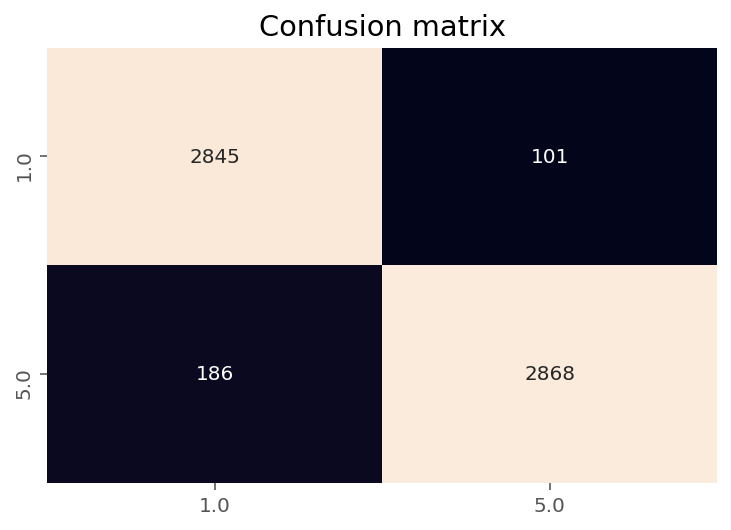

In [124]:
labels = grid_tf_idf.best_estimator_.classes_

sns.heatmap(
    data=confusion_matrix(y_test, predictions), 
    annot=True, 
    fmt="d", 
    cbar=False, 
    xticklabels=labels, 
    yticklabels=labels
)

plt.title("Confusion matrix")
plt.show()

Cингулярное разложение

In [125]:
clf_tf_idf_TruncatedSVD = Pipeline(
    [('vect', CountVectorizer()),
     ('tfidf', TfidfTransformer()),
     ('tsvd', TruncatedSVD()),
     ('clf', LogisticRegression())]
)

params_tf_idf_TruncatedSVD={
    'vect__analyzer': ['word'],
    'vect__ngram_range': [(1, 1), (2, 2), (3, 3)],
    'tsvd__n_components': [5, 10, 25, 50, 100],
    'clf__C': np.logspace(-3, 3, 7),
    'clf__penalty': ['l1', 'l2']
}

scores=['accuracy','f1']

In [126]:
grid_tf_idf_TruncatedSVD = GridSearchCV(
    clf_tf_idf_TruncatedSVD, 
    param_grid=params_tf_idf_TruncatedSVD, 
    cv=3,
    scoring=scores,
    refit=scores[0],
    n_jobs=-1, 
    verbose=1
)

In [127]:
grid_tf_idf_TruncatedSVD.fit(X_train, y_train)

Fitting 3 folds for each of 210 candidates, totalling 630 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  8.3min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed: 85.1min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed: 139.3min
[Parallel(n_jobs=-1)]: Done 630 out of 630 | elapsed: 183.7min finished


GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('vect',
                                        CountVectorizer(analyzer='word',
                                                        binary=False,
                                                        decode_error='strict',
                                                        dtype=<class 'numpy.int64'>,
                                                        encoding='utf-8',
                                                        input='content',
                                                        lowercase=True,
                                                        max_df=1.0,
                                                        max_features=None,
                                                        min_df=1,
                                                        ngram_range=(1, 1),
                                            

In [161]:
# print(grid_tf_idf_TruncatedSVD.best_estimator_)
print("Best score: %0.3f" % grid_tf_idf_TruncatedSVD.best_score_)

Best score: 0.942


In [162]:
predictions=grid_tf_idf_TruncatedSVD.best_estimator_.predict(X_test)

In [163]:
print("Precision: {0:6.2f}".format(precision_score(y_test, predictions, average='macro')))
print("Recall:    {0:6.2f}".format(recall_score(y_test, predictions, average='macro')))
print("F1_score:  {0:6.2f}".format(f1_score(y_test, predictions, average='macro')))
print("Accuracy:  {0:6.2f}".format(accuracy_score(y_test, predictions)))

Precision:   0.94
Recall:      0.94
F1_score:    0.94
Accuracy:    0.94


In [131]:
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

         1.0       0.93      0.95      0.94      2946
         5.0       0.95      0.93      0.94      3054

    accuracy                           0.94      6000
   macro avg       0.94      0.94      0.94      6000
weighted avg       0.94      0.94      0.94      6000



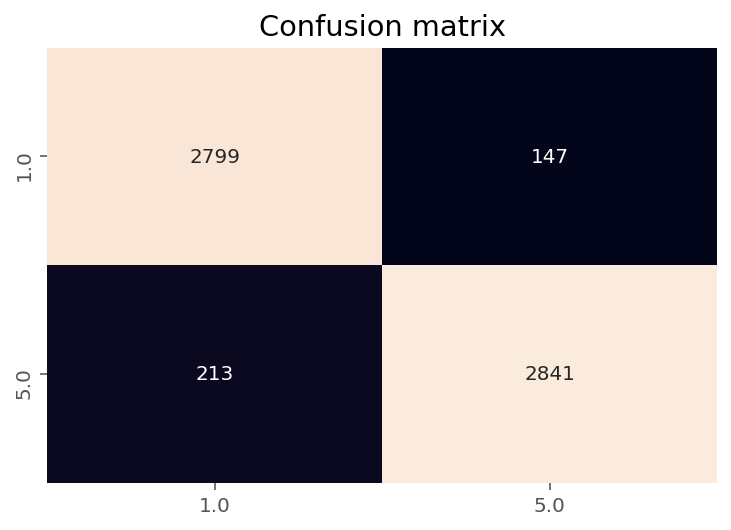

In [132]:
labels = grid_tf_idf_TruncatedSVD.best_estimator_.classes_

sns.heatmap(
    data=confusion_matrix(y_test, predictions), 
    annot=True, 
    fmt="d", 
    cbar=False, 
    xticklabels=labels, 
    yticklabels=labels
)

plt.title("Confusion matrix")
plt.show()

#### 2-ой вариант

LDA

In [136]:
clf_tf_idf_LDA = Pipeline(
    [('vect', CountVectorizer()),
     ('lda', LatentDirichletAllocation()),
     ('clf', LogisticRegression())]
)

params_tf_idf_LDA={
    'vect__analyzer': ['word'],
    'vect__max_df': [0.75],
    'vect__ngram_range': [(1, 1)],
    'lda__n_components' : [25, 50, 100],
    'clf__C': np.logspace(-3, 3, 7),
    'clf__penalty': ['l1']
}

scores=['accuracy', 'f1']

In [138]:
grid_tf_idf_LDA = GridSearchCV(
    clf_tf_idf_LDA, 
    param_grid=params_tf_idf_LDA, 
    cv=3,
    scoring=scores,
    refit=scores[0],
    n_jobs=-1, 
    verbose=1
)

In [139]:
grid_tf_idf_LDA.fit(X_train, y_train)

Fitting 3 folds for each of 21 candidates, totalling 63 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed: 38.1min
[Parallel(n_jobs=-1)]: Done  63 out of  63 | elapsed: 55.4min finished


GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('vect',
                                        CountVectorizer(analyzer='word',
                                                        binary=False,
                                                        decode_error='strict',
                                                        dtype=<class 'numpy.int64'>,
                                                        encoding='utf-8',
                                                        input='content',
                                                        lowercase=True,
                                                        max_df=1.0,
                                                        max_features=None,
                                                        min_df=1,
                                                        ngram_range=(1, 1),
                                            

In [140]:
# print(grid_tf_idf_LDA.best_estimator_)
print("Best score: %0.3f" % grid_tf_idf_LDA.best_score_)

Best score: 0.912


In [164]:
predictions=grid_tf_idf_LDA.best_estimator_.predict(X_test)

In [165]:
print("Precision: {0:6.2f}".format(precision_score(y_test, predictions, average='macro')))
print("Recall:    {0:6.2f}".format(recall_score(y_test, predictions, average='macro')))
print("F1_score:  {0:6.2f}".format(f1_score(y_test, predictions, average='macro')))
print("Accuracy:  {0:6.2f}".format(accuracy_score(y_test, predictions)))

Precision:   0.92
Recall:      0.92
F1_score:    0.92
Accuracy:    0.92


In [143]:
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

         1.0       0.90      0.93      0.91      2946
         5.0       0.93      0.90      0.92      3054

    accuracy                           0.92      6000
   macro avg       0.92      0.92      0.92      6000
weighted avg       0.92      0.92      0.92      6000



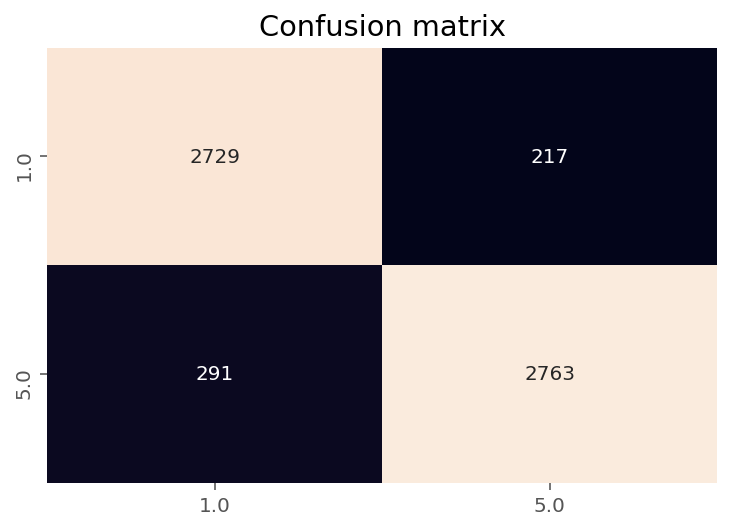

In [144]:
labels = grid_tf_idf_LDA.best_estimator_.classes_

sns.heatmap(
    data=confusion_matrix(y_test, predictions), 
    annot=True, 
    fmt="d", 
    cbar=False,
    xticklabels=labels,
    yticklabels=labels
)

plt.title("Confusion matrix")
plt.show()

### Итого:

In [151]:
models=['grid_cntv', 'grid_tf_idf', 'grid_tf_idf_TruncatedSVD', 'grid_tf_idf_LDA']

for model in models:
    print(model[5:])
    predictions=eval(model).best_estimator_.predict(X_test)
    print("f1_score: {0:6.3f}\nAccuracy: {0:6.3f}\n\n".format(
        f1_score(y_test, predictions, average='macro'), 
        accuracy_score(y_test, predictions)))

cntv
f1_score:  0.948
Accuracy:  0.948


tf_idf
f1_score:  0.952
Accuracy:  0.952


tf_idf_TruncatedSVD
f1_score:  0.940
Accuracy:  0.940


tf_idf_LDA
f1_score:  0.915
Accuracy:  0.915




**𝑡𝑓−𝑖𝑑𝑓 наиболее удачная модель**

# Вывод датасет очень большой и требует очень много времени на расчеты

1. Грамотное определение стратегий работы с текстом и понимание сути датасета помогает его анализу
2. Работа с текстом требует его грамотной подготовки, так как есть риски потери сути
3. Инструменты nlp помогают значительно быстрее классифицировать обращения без использования человеческого труда и драгоценной экспертизы сотрудников